In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import streaming_classifier








In [5]:
# Load in all training data


waves, labels, samprate = load_training_data(path = "Datasets/",
                       scale_factor= 1,
                       blacklist = ['data0'],
                       whitelist = ["data"])

samprate = 10000



dict_keys(['data3', 'data2', 'data1', 'data5', 'data4']) dict_keys(['data1', 'data3', 'data2', 'data5', 'data4'])


/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Classifier/load_data.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


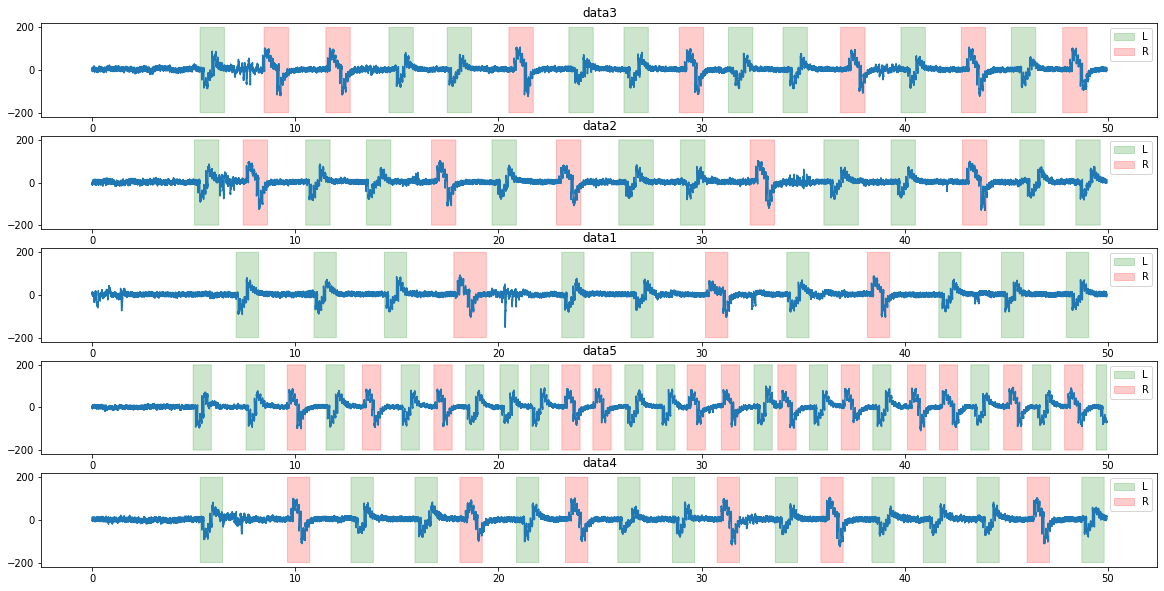

In [6]:
fig, ax = plt.subplots(len(waves), 1)
fig.set_size_inches((20, len(waves)*2))

time_buffers = {"data3":(-0.1, 1.3),
                "data2":(-0.2, 1.4),
                "data0":(-0.1, 1.3),
                "data1":(-0.3, 1.4),
                "data5":(-0.4, 1.3),
                "data4":(-0.2, 1.3)}


i=0
for key in waves.keys():
    
    wav_array = waves[key]
    labels_dat = labels[key]
        
    
    plot_labelled_wave(wav_array, samprate, labels_dat, ax, i, title=key, before_buffer = time_buffers[key][0],
                       after_buffer = time_buffers[key][1], shade_alpha=0.2, wave_alpha=1, ymin = -200, ymax = 200)
    
    
    i+=1
    
    


/Users/billydodds/.pyenv/versions/3.9.0/envs/data3888/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


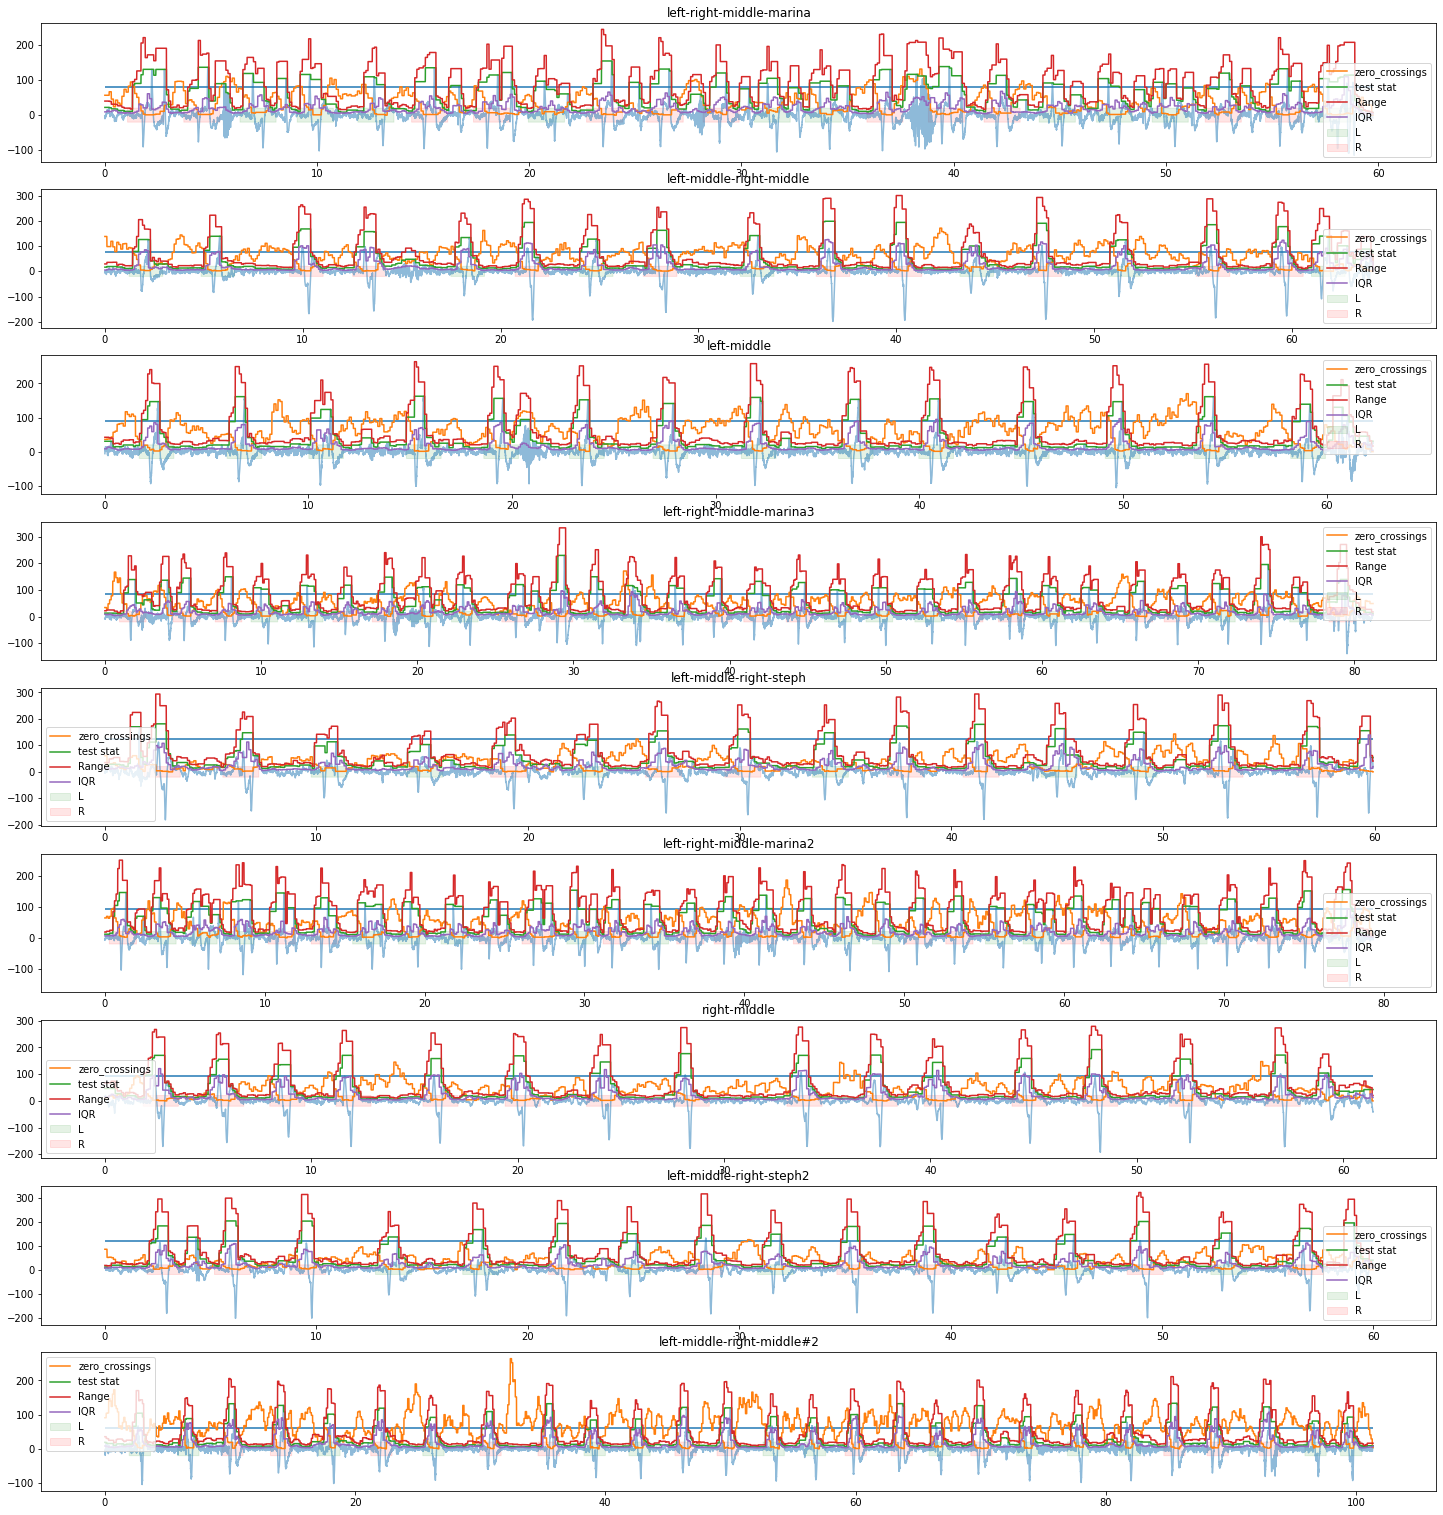

In [5]:



### Smart Thresholding ###
st_window = 10 # Seconds
st_scale = 0.35

st_window_ind = st_window*samprate


test_stat_function = lambda x: np.max(np.abs(np.array([np.max(x), np.min(x)])))




fig, ax = plt.subplots(len(waves), 1)
fig.set_size_inches((25, 3*len(waves)))



i=0
for key in waves.keys():
    
    wav_array = waves[key]
    labels_dat = labels[key]
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    
    plot_labelled_wave(wav_array, samprate, labels_dat, ax, i, title=key, wave_alpha=0.5, shade_alpha=0.1, ymin = -20, ymax = 20)

    
    
    index = 0
    step = int(0.1*samprate)
    window = int(0.5*samprate)
    test_stat = np.array([None]*len(wav_array))
    test_stat_zerocrossings = np.array([None]*len(wav_array))
    test_stat_iqr = np.array([None]*len(wav_array))
    test_stat_range = np.array([None]*len(wav_array))
    test_stat_sd = np.array([None]*len(wav_array))

    while index + 1 < len(wav_array):
        subset = wav_array[index:(index+window)]

#         test_stat_absmax[index:index+step] = np.max(np.abs(subset))
        zero_thresh = 0
        test_stat_zerocrossings[index:index+step] = np.sum( (subset[0:-1]+zero_thresh) * (subset[1::]+zero_thresh) <= 0)
#         test_stat_max_change[index:index+step] = np.max(np.abs(np.diff(subset)))
        test_stat_range[index:index+step] = np.max(subset) - np.min(subset)
    
        test_stat_iqr[index:index+step] = np.quantile(subset, 0.75) - np.quantile(subset, 0.25)
    
    
        test_stat[index:index+step] = test_stat_function(subset)
        
#         test_stat_sd[index:index+step] = np.std(subset)
        index += step

#     ax[i].plot(time_seq, test_stat_absmax, label="max(abs(x))")
    ax[i].plot(time_seq, test_stat_zerocrossings, label="zero_crossings")
    ax[i].plot(time_seq, test_stat, label="test stat")
#     ax[i].plot(time_seq, test_stat_max_change*100, label="max change")
    ax[i].plot(time_seq, test_stat_range, label="Range")
    ax[i].plot(time_seq, test_stat_iqr, label="IQR")
#     ax[i].plot(time_seq, test_stat_sd, label="SD")
    
    
    ## Smart threshold
    st_subset = wav_array[0:st_window_ind]
    st_range = np.max(st_subset) - np.min(st_subset)
    st_threshold = st_range*st_scale
    
    ax[i].hlines(st_threshold, time_seq[0], time_seq[-1], )
    ax[i].legend()
    
#     ax[i].set_ylim(-20, 20)
    
    i+=1





In [5]:
from copy import deepcopy


for st_scale in np.linspace(0.2, 0.8, 20):

    fps = 0
    fns = 0


    ### Smart Thresholding ###
    st_window = 10 # Seconds
#     st_scale = 0.35


    # %matplotlib notebook

    before_buffer = 0.7
    after_buffer = 1


#     fig, ax = plt.subplots(len(waves), 1)
#     fig.set_size_inches(10, 3*len(waves))



    i=0
    for key in waves.keys():

        predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                                                                        waves[key],
                                                                        samprate,
                                                                        window_size = 1.5, # time plotted in window [s]
                                                                        N_loops_over_window = 15, # implicitly defines buffer to be 1/x of the window
                                                                        total_time = None,  # max time
                                                                        hyp_detection_buffer_end = 0.3, # seconds - how much time to shave off either end of the window in order to define the middle portion
                                                                        hyp_detection_buffer_start = 0.7,
                                                                        hyp_event_smart_threshold_window = st_window, 
                                                                        hyp_event_smart_threshold_factor = st_scale, 
                                                                        hyp_event_history = 5,
                                                                        hyp_consecutive_triggers = 3,
                                                                        hyp_consecutive_reset = 1,
                                                                        plot = False,
                                                                        store_events = True, 
                                                                        verbose=False,
                                                                        live = False)


    #     plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i, title=key, actual_alpha=0.2)


        actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
        actual_leftovers = deepcopy(actual_times)
        pred_leftovers = deepcopy(predictions_timestamps)


        for act_times in actual_times:
            if act_times[1] < st_window:
                actual_leftovers.remove(act_times)
                continue
            for pred_times in predictions_timestamps:
                if act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and pred_times in pred_leftovers and act_times in actual_leftovers:
                    actual_leftovers.remove(act_times)
                    pred_leftovers.remove(pred_times)



    #     plot_detection_errors(waves[key], samprate, pred_leftovers, actual_leftovers, ax, i, title=key, alpha=0.7)
    #     plot_labelled_wave(waves[key], samprate, labels[key], ax, i, wave_alpha=0)
#         ax[i].set_xlim(-13)


#         print("File: ", key)
#         print(f"False negative triggers: {len(actual_leftovers)}", actual_leftovers)
#         print(f"False positive triggers: {len(pred_leftovers)}",  pred_leftovers)
        
        fns += len(actual_leftovers)
        fps += len(pred_leftovers)


        i+=1
        
    print(st_scale, fns, fps)


0.2 0 39
0.23157894736842108 0 33
0.26315789473684215 0 30
0.2947368421052632 0 28
0.3263157894736842 0 28
0.3578947368421053 0 29
0.38947368421052636 0 33
0.42105263157894746 0 31
0.4526315789473685 1 34
0.48421052631578954 1 35
0.5157894736842106 4 33
0.5473684210526317 9 29
0.5789473684210527 16 20
0.6105263157894738 29 17
0.6421052631578948 43 7
0.6736842105263159 59 3
0.705263157894737 69 4
0.736842105263158 81 2
0.7684210526315791 91 0
0.8 97 0


In [7]:
hyp_calibration_statistic_function = lambda x: np.quantile(x, 0.75) - np.quantile(x, 0.25)



from copy import deepcopy


for st_scale in np.linspace(1, 10, 30):

    fps = 0
    fns = 0


    ### Smart Thresholding ###
    st_window = 5 # Seconds
#     st_scale = 0.35


    # %matplotlib notebook

    before_buffer = 0.7
    after_buffer = 1


#     fig, ax = plt.subplots(len(waves), 1)
#     fig.set_size_inches(10, 3*len(waves))



    i=0
    for key in waves.keys():

        predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                                                                        waves[key],
                                                                        samprate,
                                                                        window_size = 1.5, # time plotted in window [s]
                                                                        N_loops_over_window = 15, # implicitly defines buffer to be 1/x of the window
                                                                        total_time = None,  # max time
                                                                        hyp_detection_buffer_end = 0.3, # seconds - how much time to shave off either end of the window in order to define the middle portion
                                                                        hyp_detection_buffer_start = 0.7,
                                                                        hyp_event_smart_threshold_window = st_window, 
                                                                        hyp_event_smart_threshold_factor = st_scale, 
                                                                        hyp_calibration_statistic_function = hyp_calibration_statistic_function,
                                                                        hyp_event_history = 5,
                                                                        hyp_consecutive_triggers = 3,
                                                                        hyp_consecutive_reset = 1,
                                                                        plot = False,
                                                                        store_events = True, 
                                                                        verbose=False,
                                                                        live = False)


    #     plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i, title=key, actual_alpha=0.2)


        actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
        actual_leftovers = deepcopy(actual_times)
        pred_leftovers = deepcopy(predictions_timestamps)


        for act_times in actual_times:
            if act_times[1] < st_window:
                actual_leftovers.remove(act_times)
                continue
            for pred_times in predictions_timestamps:
                if act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and pred_times in pred_leftovers and act_times in actual_leftovers:
                    actual_leftovers.remove(act_times)
                    pred_leftovers.remove(pred_times)



    #     plot_detection_errors(waves[key], samprate, pred_leftovers, actual_leftovers, ax, i, title=key, alpha=0.7)
    #     plot_labelled_wave(waves[key], samprate, labels[key], ax, i, wave_alpha=0)
#         ax[i].set_xlim(-13)


#         print("File: ", key)
#         print(f"False negative triggers: {len(actual_leftovers)}", actual_leftovers)
#         print(f"False positive triggers: {len(pred_leftovers)}",  pred_leftovers)
        
        fns += len(actual_leftovers)
        fps += len(pred_leftovers)


        i+=1
        
    print(st_scale, fns, fps)




1.0 153 17
1.3103448275862069 112 35
1.6206896551724137 59 50
1.9310344827586208 25 69
2.2413793103448274 12 82
2.5517241379310347 5 75
2.8620689655172415 2 72
3.1724137931034484 0 65
3.4827586206896552 0 61
3.793103448275862 0 52
4.103448275862069 0 48
4.413793103448276 0 44
4.724137931034483 0 43
5.0344827586206895 0 41
5.344827586206897 0 38
5.655172413793103 0 39
5.9655172413793105 0 38
6.275862068965518 0 36
6.586206896551724 0 33
6.8965517241379315 0 34
7.206896551724138 1 36
7.517241379310345 1 37
7.827586206896552 2 40
8.137931034482758 3 39
8.448275862068966 3 36
8.758620689655173 6 32
9.068965517241379 8 31
9.379310344827587 9 33
9.689655172413794 13 28
10.0 18 24


UnboundLocalError: local variable 'timer' referenced before assignment

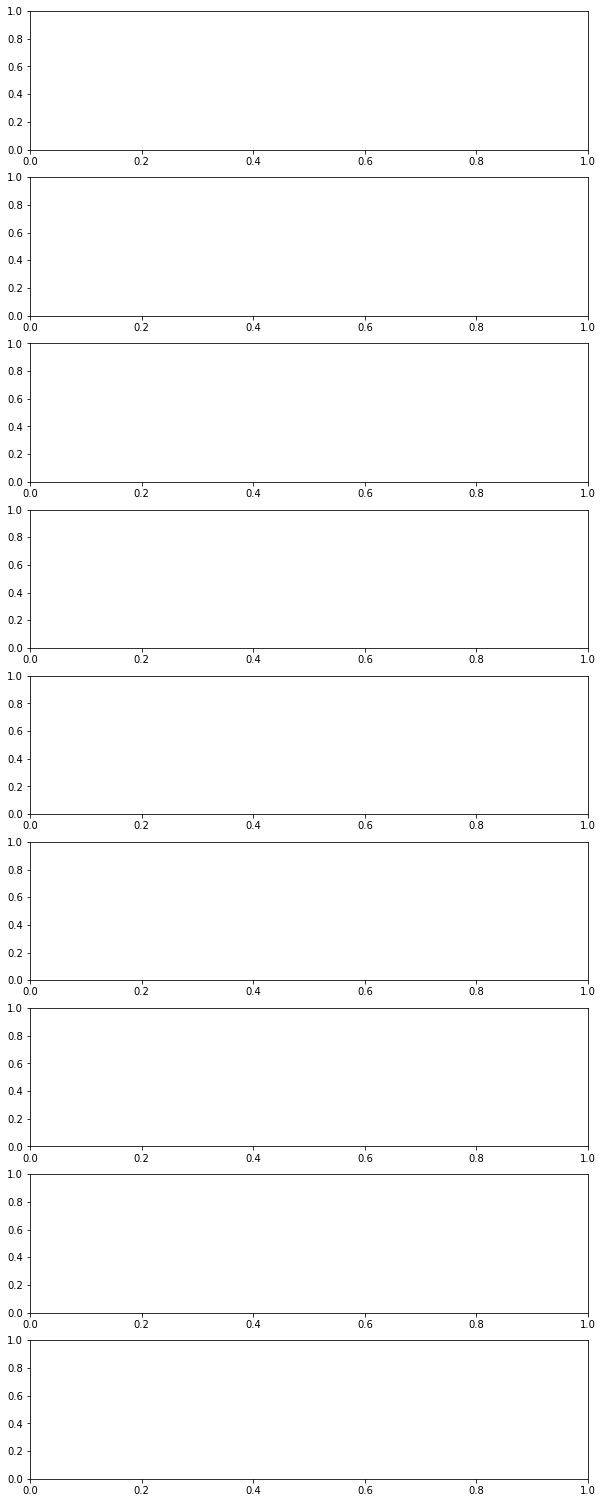

In [4]:

hyp_calibration_statistic_function = lambda x: np.quantile(x, 0.75) - np.quantile(x, 0.25)

st_scale = 6.89


st_window = 5 # Seconds
#     st_scale = 0.35


# %matplotlib notebook

before_buffer = 0.7
after_buffer = 1


fig, ax = plt.subplots(len(waves), 1)
fig.set_size_inches(10, 3*len(waves))


fns = 0
fps = 0


i=0
for key in waves.keys():

    predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                                                                    waves[key],
                                                                    samprate,
                                                                    window_size = 1.5, # time plotted in window [s]
                                                                    N_loops_over_window = 15, # implicitly defines buffer to be 1/x of the window
                                                                    total_time = None,  # max time
                                                                    hyp_detection_buffer_end = 0.3, # seconds - how much time to shave off either end of the window in order to define the middle portion
                                                                    hyp_detection_buffer_start = 0.7,
                                                                    hyp_event_smart_threshold_window = st_window, 
                                                                    hyp_event_smart_threshold_factor = st_scale, 
                                                                    hyp_calibration_statistic_function = hyp_calibration_statistic_function,
                                                                    hyp_event_history = 10,
                                                                    hyp_consecutive_triggers = 3,
#                                                                     hyp_consecutive_reset = 7,
                                                                    hyp_timeout = 5,
                                                                    plot = False,
                                                                    store_events = True, 
                                                                    verbose=False,
                                                                    live = False,
                                                                    timeout=True)


#     plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i, title=key, actual_alpha=0.2)


    actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
    actual_leftovers = deepcopy(actual_times)
    pred_leftovers = deepcopy(predictions_timestamps)


    for act_times in actual_times:
        if act_times[1] < st_window:
            actual_leftovers.remove(act_times)
            continue
        for pred_times in predictions_timestamps:
            if act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and pred_times in pred_leftovers and act_times in actual_leftovers:
                actual_leftovers.remove(act_times)
                pred_leftovers.remove(pred_times)



    plot_detection_errors(waves[key], samprate, pred_leftovers, actual_leftovers, ax, i, title=key, alpha=0.7)
#     plot_labelled_wave(waves[key], samprate, labels[key], ax, i, wave_alpha=0)
#         ax[i].set_xlim(-13)


#         print("File: ", key)
#         print(f"False negative triggers: {len(actual_leftovers)}", actual_leftovers)
#         print(f"False positive triggers: {len(pred_leftovers)}",  pred_leftovers)

    fns += len(actual_leftovers)
    fps += len(pred_leftovers)


    i+=1
    
print(fns, fps)


